In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
from sklearn.decomposition import PCA
import os
import pandas as pd

In [2]:
from scipy.ndimage.filters import uniform_filter1d

In [3]:
col_list = ['#ed392b', '#feb441', '#4090c5']
col_max = ['#af1117', '#ea6e13', '#0f59a3']
gene_list = ['tbxta', 'tbx16', 'tbx6']
emb_cmap = ['Reds', 'YlOrBr', 'Blues']
large_colours = ['#692606', '#8e3104', '#08326e']
gene_codes = ['g1', 'g2', 'g3']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lato', 'Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']

plt.rcParams['font.sans-serif'] = ['Lato']

plt.rcParams['font.size'] = 10


In [4]:
files = os.listdir('../output/simulations/')
files = [i for i in files if 'simulation' in i]
files= [i for i in files if '40000' in i or 'restart' in i]
files = [i for i in files if 'perturbed_signalling' not in i]


dat = []

for f in files:
    try:
        data = pd.read_csv('../output/simulations/' + f)
        dat.append(data)
    except:
        print(f)

data = pd.concat(dat)
data = data[data['3'] > -500000]
data['nAget'] = [int(i.split('_')[1].split('run')[1]) for i in data['0']]


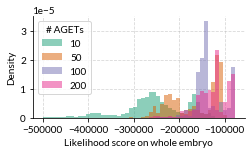

In [5]:


# plt.figure(figsize=(4, 2.5), tight_layout = True)

colours = ['red', 'green', 'pink', 'black']

from matplotlib.cm import get_cmap

name = "Dark2"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

bins = np.linspace(np.min(data['3']), np.max(data['3']), 50)

scaling = .9

fig, ax = plt.subplots(1,1, figsize=(4*scaling, 2.5*scaling), tight_layout = True)

for i, nAget in enumerate([10, 50, 100, 200]):
    plt.hist(
        data.loc[data['nAget'] == nAget, '3'],
        bins = bins, color = colors[i], alpha = 0.5, label = nAget,
        density = True)



ax.set_axisbelow(True)
ax.grid(True, linestyle='--', alpha=0.5, zorder= 0)
# axs.axvline(0, alpha = 0.3, color='black', linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



plt.legend(title="# AGETs",fancybox=True)
plt.xlabel('Likelihood score on whole embryo')
plt.ylabel('Density')

plt.savefig('../graphs/Likelyhood score histogram 2.png', dpi = 500)

In [7]:
from cProfile import run
import numpy as np

import liveModelling
import liveModelling.simulate as simulate
from liveModelling import mcmc_functions as mcmc_functions

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.ticker as ticker

import pickle

def PSH(s, t, wnt, fgf, params):

    B = np.array([wnt, fgf])

    W = np.array([[params[0] , params[1], params[2]],\
                 [ params[3],  params[4], params[5]],\
                 [ params[6],  params[7], params[8]]])

    E = np.array([[params[18],params[17]],[params[19],params[15]],[params[20],params[16]]])
    R = [params[9],  params[10],  params[11]]
    lmd = [params[12],  params[13] , params[14]]
    h = [params[21],  params[22] , params[23]]


    u0 = W[0][0]*s[0] + W[0][1]*s[1] + W[0][2]*s[2] + E[0].dot(B) + h[0]
    u1 = W[1][0]*s[0] + W[1][1]*s[1] + W[1][2]*s[2] + E[1].dot(B) + h[1]
    u2 = W[2][0]*s[0] + W[2][1]*s[1] + W[2][2]*s[2] + E[2].dot(B) + h[2]

    d_tbxta_dt = R[0] * g(u0)  - lmd[0]* s[0]
    d_tbx16_dt = R[1] * g(u1)  - lmd[1]* s[1]
    d_tbx24_dt = R[2] * g(u2)  - lmd[2]* s[2]

    dsdt = [d_tbxta_dt, d_tbx16_dt, d_tbx24_dt]

    return dsdt


def g(x):
    return 0.5 * ((x / np.sqrt(x ** 2 + 1)) + 1)

class Simulate_on_tracks:
    '''
    The simulator takes as input a set of 24 parameters describing the GRN
    and uses ODEs with the initial and boundary conditions from the AGETs to
    simulate gene expression for the chosen 10 AGETs. The simulated gene expression
    is then added to the AGET, so that the AGET includes the original target as well
    as the simulated gene expression.
    '''

    def __init__(self, parameters, list_of_tracks, static = False):
        self.params = parameters
        self.list_of_tracks = list_of_tracks
        self.static = static

    def simulation(self):
        params = self.params
        tracks_df = self.list_of_tracks

        # precompute t_intervals to speed up function
        base_t_intervals = []
        for i in range(1, 61): # number of timepoints
            t_interval = np.linspace(i*90/3600/3, (i+1)*90/3600/3, 10)
            base_t_intervals.append(t_interval)

        # precompute the Time_nPSM
        time_npsm = [i*90/3600/3 for i in range(1, 62)]


        # add the params to an empty array of shape (26) to pass to PSH_lsoda
        params_to_pass = np.empty((26, ))
        params_to_pass[0:24] = params

        df_out = []
        # Iterate through celltracks (AGETs)
        for df_celltrack in tracks_df:
            # add biological time for the ODEs
            # I precomputed this earlier to speed up the iterations
            df_celltrack = df_celltrack.reset_index(drop = True)
            if df_celltrack.shape[0] == 61:
                df_celltrack['Time_nPSM'] = time_npsm
            else:
                df_celltrack['Time_nPSM'] = df_celltrack['Time']*90/3600/3


            if (df_celltrack.shape[0]==0):
                continue

            # collect parameters / ICs
            simulated_expression = [df_celltrack.loc[0, ['g1', 'g2', 'g3']].values]
            B1 = df_celltrack['Wnt'].values
            B2 = df_celltrack['FGF'].values
            Time_nPSM = df_celltrack['Time_nPSM'].values
            time = df_celltrack['Time'].values

            # loop through positions in dataframe
            for index in df_celltrack.index[:-1]:
                # if the timestep = 1,
                # we can use the precomputed information above
                count_timesteps_between = time[index+1] - time[index]
                if count_timesteps_between != 1:
                    t_interval = np.linspace(Time_nPSM[index], Time_nPSM[index+1], 10*int(count_timesteps_between))
                else:
                    t_interval = base_t_intervals[int(time[index])-1]

                # define initial conditions
                # and signalling
                s0 = simulated_expression[-1]
                if self.static:
                    params_to_pass[24:26] =  [B1[0], B2[0]]
                else:
                    params_to_pass[24:26] =  [B1[index], B2[index]]
                    #print( [B1[index], B2[index]])

                simulated_expression.append(simulate.solve_lsoda(
                    s0,
                    t_interval,
                    params_to_pass
                    )[-1]
                )

            simulated_expression = np.array(simulated_expression)
            df_celltrack['g1_sim'] = simulated_expression[:, 0]
            df_celltrack['g2_sim'] = simulated_expression[:, 1]
            df_celltrack['g3_sim'] = simulated_expression[:, 2]
            df_out.append(df_celltrack) # append AGET with the simulated expression to the output list

        return df_out


In [8]:
# params = np.load('runs/map_params_runrun_8_mod_aget.txt', allow_pickle=True)
import pickle
sim = pd.read_csv(f'../Input/network7_sim_data.csv')
sim_t1 = sim[sim['Time'] == 1]
min_x = min(sim_t1['X'])
max_x = max(sim_t1['X'])

sim_t1['x_norm'] = (sim_t1['X'] - min_x) / (max_x - min_x)
data_subset = sim_t1[sim_t1['x_norm'] < 0.2]
data_subset = data_subset.reset_index(drop = True)


with open("../Input/List_of_all_cell_tracks_starttoend.txt", "rb") as fp:
    list_of_cell_tracks = pickle.load(fp) # Load the chosen AGETs#





c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
params = np.array(pd.read_csv('MAP_params.csv').iloc[:, 1])

param_names = [
    'tbxta-tbxta', 'tbx16-tbxta', 'tbx6-tbxta',
    'tbxta-tbx16', 'tbx16-tbx16', 'tbx6-tbx16',
    'tbxta-tbx6', 'tbx16-tbx6', 'tbx6-tbx6',
    'tbxta production', 'tbx16 production', 'tbx6 production',
    'tbxta degradation', 'tbx16 degradation', 'tbx6 degradation',
    'FGF-tbx16', 'FGF-tbx6', 'FGF-tbxta', 'Wnt-tbxta', 'Wnt-tbx16', 'Wnt-tbx6',
    'basal tbxta', 'basal tbx16', 'basal tbx6'
    ]

for i in range(24):
    print(param_names[i], params[i])

# print([i for i in params])

tbxta-tbxta 0.6649207002602573
tbx16-tbxta -3.326276331671914
tbx6-tbxta -10.888601525577792
tbxta-tbx16 0.3047395724767924
tbx16-tbx16 0.0081576715701516
tbx6-tbx16 -0.7959331154065472
tbxta-tbx6 1.5230912196318251
tbx16-tbx6 -12.307874016229528
tbx6-tbx6 0.001100520426661
tbxta production 28.51767322379712
tbx16 production 159.90710003344077
tbx6 production 2.7365856165303244
tbxta degradation 5.148029361936042
tbx16 degradation 87.40481066816469
tbx6 degradation 1.6642573898290554
FGF-tbx16 0.790550815271675
FGF-tbx6 8.756625350604827
FGF-tbxta 0.8151283166472618
Wnt-tbxta 1.6587262490088044
Wnt-tbx16 0.5113998720868309
Wnt-tbx6 6.627076777730141
basal tbxta 0.0611682384103569
basal tbx16 -0.9233773508255516
basal tbx6 -0.8987024430076592


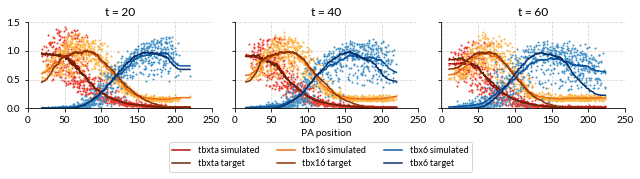

In [11]:
fig, axs_ = plt.subplots(2,3,
                        sharex = False,
                        sharey = True,
                        tight_layout = True, figsize = (9, 2.5),
                        gridspec_kw={'height_ratios': [1, 0.2]})

axs = axs_[0]

sim = pd.read_csv('../Input/network7_sim_data.csv')
# sim = pd.read_csv('../output/simulations/Sim_samples_run200_AGETs.15_randomnumber.10000_it.200_walkers.1_technicalreplicate.txt_final_timepoint_samp.txt0')
files = os.listdir('../output')

trackIDs = np.random.choice(np.unique(sim['TrackID']), 9)

sim = pd.concat(Simulate_on_tracks(params, list_of_cell_tracks).simulation())

for i, timepoint in enumerate([20, 40, 60]):
    sim_subset = sim[sim['Time'] == timepoint]

    for k in range(3):
        # ax.plot(sim_subset['Time'], sim_subset[gene_codes[j]], c = col_max[j], linewidth = 1)
        ax = axs[i]
        ax.scatter(
            sim_subset['X'], sim_subset[gene_codes[k] + '_sim'],
            c = col_list[k], s = 1)#, label = gene_list[k])


        yhat_1 = uniform_filter1d(
            sim_subset.sort_values("X")[f'g{k+1}'], size = 75, mode = 'nearest')
        yhat_2 = uniform_filter1d(
            sim_subset.sort_values("X")[f'g{k+1}_sim'], size = 75, mode = 'nearest')
        ax.plot(sim_subset.sort_values("X")['X'],
                    yhat_2, color = col_max[k],
                    label = f'{gene_list[k]} simulated')
        ax.plot(sim_subset.sort_values("X")['X'],
                    yhat_1, color = large_colours[k],
                    label = f'{gene_list[k]} target')

    ax.set_title(f't = {timepoint}')

    # axs[0].plot(sim_subset.sort_values("X")['X'],
    #             yhat_1, color = 'black',
    #             label = 'target')



for ax in axs.flatten():
    ax.set_ylim(0, 1.5)
    ax.grid(True, linestyle='--', alpha=0.5, zorder= 0)
    # ax.axvline(0, alpha = 0.3, color='black', linewidth=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0, 50, 100, 150, 200, 250])

for ax in axs_[1]:
    ax.axis('off')

# Set legend properties
lgd = fig.legend(
    axs[0].get_legend_handles_labels()[1],
    bbox_to_anchor=(0.5, 0.0),
    loc='lower center',
    fontsize="9",
    ncol=3 # Number of columns in the legend
)

axs[1].set_xlabel('PA position')
# fig.suptitle('best parameter set')

plt.savefig('../graphs/Pattern on embryo timecourse.png', dpi=500)

In [12]:
keep_tracks = [track for track in list_of_cell_tracks if track['X'].values[-1] < 170]


In [13]:
rng = np.random.default_rng(423)
fitted_to = rng.choice(keep_tracks, 200, replace = False)
fitted_to_df = pd.concat(fitted_to)

c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [14]:
fitted_to_t1 = pd.DataFrame([i.iloc[0] for i in fitted_to])
fitted_to_t1 = fitted_to_t1.sort_values(by = 'X', ascending = True)
fitted_to_ids = list(fitted_to_t1['TrackID'])

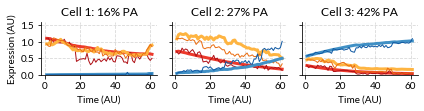

In [15]:
fig, axs = plt.subplots(1,3,
                        sharex = True, sharey = True,
                        tight_layout = True, figsize = (6,6/4*1.1))


trackIDs2 = [fitted_to_ids[66], fitted_to_ids[120], fitted_to_ids[180]]

sim = pd.read_csv(f'../Input/network7_sim_data.csv')

minx = np.min(sim['X'])
maxx = np.max(sim['X'])


# sim = Simulate_on_tracks(params, trackIDs2).simulation()

# for i, track in enumerate(sim):
for i, track in enumerate(trackIDs2):
    # sim_subset = track.reset_index(drop = True)
    sim_subset = Simulate_on_tracks(params, #
                                    [fitted_to_df[fitted_to_df['TrackID'] == track]]
                                    ).simulation()[0]
    ax = axs[i]
    for j in range(3):
        # ax.plot(sim_subset['Time'], sim_subset[gene_codes[j]], c = col_max[j], linewidth = 1)
        ax.plot(
            sim_subset['Time'],
            sim_subset[gene_codes[j] + '_sim'],
            c = col_list[j], linewidth = 3,
            label = gene_list[j] + ' simulation')
        ap_pos = round((list(sim_subset['X'])[0] - minx) / (maxx - minx) * 100)
        ax.set_title(f'Cell {i+1}: {ap_pos}% PA')

        ax.plot(sim_subset['Time'], sim_subset[gene_codes[j]], c = col_max[j], linewidth = 1, label = gene_list[j] + ' AGET')






for ax in axs.flatten():
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', alpha=0.5, zorder= 0)
    # ax.axvline(0, alpha = 0.3, color='black', linewidth=1)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0, 1.6)
    ax.set_yticks(np.array([0, 0.5, 1.0, 1.5]))



for i in range(3):
    axs[0].set_ylabel('Expression (AU)')
    axs[i].set_xlabel('Time (AU)')
    axs[i].set_xticks([0, 20, 40, 60])
# handles = [l1, l2]




# for i, track in enumerate(trackIDs2):
#     sim_subset = track.reset_index(drop = True)


plt.savefig('../graphs/Expression in individual cells fitted to.png', dpi = 500)


In [16]:
fitted_to_trackIDs = np.unique(pd.concat(fitted_to)['TrackID'])

In [17]:
not_fitted_to = [track for track in list_of_cell_tracks if track['TrackID'].values[0] not in fitted_to_trackIDs]

not_fitted_to_df = pd.concat(not_fitted_to)

not_fitted_to_t1 = pd.DataFrame([i.iloc[0] for i in not_fitted_to])
not_fitted_to_t1 = not_fitted_to_t1.sort_values(by = 'X', ascending = True)
not_fitted_to_ids = list(not_fitted_to_t1['TrackID'])

In [18]:
len(not_fitted_to_ids)

629

c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


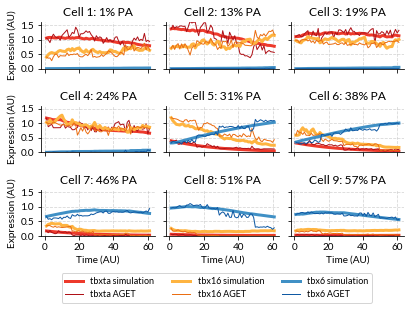

In [19]:
fig, axs = plt.subplots(3,3,
                        sharex = True, sharey = True,
                        tight_layout = True,
                        gridspec_kw={'hspace': .8, 'wspace': 0.1},   # Adjust hspace and wspace as needed
                        figsize = (6.5, 6/4*3))


# fig.tight_layout(rect=[0,0,0,.8])

trackIDs1 = np.random.choice(not_fitted_to, 9)

# Calculate the step size to select evenly spaced entries
step = len(not_fitted_to_ids) // 9

# Select 9 evenly spaced entries from the list
trackIDs1 = not_fitted_to_ids[::step][:9]

sim = pd.read_csv(f'../Input/network7_sim_data.csv')

minx = np.min(sim['X'])
maxx = np.max(sim['X'])


# sim = Simulate_on_tracks(params, trackIDs1).simulation()

# for i, track in enumerate(sim):
for i, track in enumerate(trackIDs1):
    # sim_subset = track.reset_index(drop = True)
    sim_subset = Simulate_on_tracks(params, #
                                    [not_fitted_to_df[not_fitted_to_df['TrackID'] == track]]
                                    ).simulation()[0]
    # sim_subset = track.reset_index(drop = True)
    ax = axs.flatten()[i]
    for j in range(3):
        # ax.plot(sim_subset['Time'], sim_subset[gene_codes[j]], c = col_max[j], linewidth = 1)
        ax.plot(
            sim_subset['Time'],
            sim_subset[gene_codes[j] + '_sim'],
            c = col_list[j], linewidth = 3,
            label = gene_list[j] + ' simulation')

        ax.plot(sim_subset['Time'], sim_subset[gene_codes[j]],
                c = col_max[j], linewidth = 1, label = gene_list[j] + ' AGET')


        ap_pos = round((list(sim_subset['X'])[0] - minx) / (maxx - minx) * 100)
        ax.set_title(f'Cell {i+1}: {ap_pos}% PA')


for ax in axs.flatten():
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', alpha=0.5, zorder= 0)
    # ax.axvline(0, alpha = 0.3, color='black', linewidth=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0, 1.6)
    ax.set_yticks(np.array([0, 0.5, 1.0, 1.5]))

fig.subplots_adjust(bottom=0.22) # or whatever

# Set legend properties
lgd = fig.legend(
    axs[0, 0].get_legend_handles_labels()[1],
    bbox_to_anchor=(0.5, -0),
    loc='lower center',
    fontsize="9",
    ncol=3  # Number of columns in the legend
)


for i in range(3):
    axs[i, 0].set_ylabel('Expression (AU)')
    axs[-1, i].set_xlabel('Time (AU)')
    axs[-1, i].set_xticks([0, 20, 40, 60])
# handles = [l1, l2]



plt.savefig(
    '../graphs/Expression in individual cells not fitted to.png',
    bbox_inches='tight', dpi = 500, facecolor='white', transparent=False)

plt.show()

In [27]:
track

1000112638.0

c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


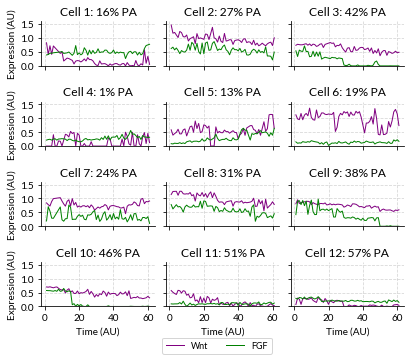

In [34]:
trackIDs_for_wntfgf = trackIDs2 + trackIDs1



fig, axs = plt.subplots(4,3,
                        sharex = True, sharey = True,
                        tight_layout = True,
                        gridspec_kw={'hspace': .8, 'wspace': 0.1},   # Adjust hspace and wspace as needed
                        figsize = (6.5, 6/4*4))


trackIDs1 = not_fitted_to_ids[::step][:9]

sim = pd.read_csv(f'../Input/network7_sim_data.csv')

minx = np.min(sim['X'])
maxx = np.max(sim['X'])


# sim = Simulate_on_tracks(params, trackIDs1).simulation()

# for i, track in enumerate(sim):
for i, track in enumerate(trackIDs_for_wntfgf):
    # sim_subset = track.reset_index(drop = True)
    sim_subset = sim[sim['TrackID'] == track]
    # sim_subset = track.reset_index(drop = True)
    ax = axs.flatten()[i]
    ax.plot(
        sim_subset['Time'],
        sim_subset['Wnt'],
        c = 'purple', linewidth = 1,
        label = 'Wnt')

    ax.plot(
        sim_subset['Time'],
        sim_subset['FGF'],
        c = 'green', linewidth = 1,
        label = 'FGF')

    ap_pos = round((list(sim_subset['X'])[0] - minx) / (maxx - minx) * 100)
    ax.set_title(f'Cell {i+1}: {ap_pos}% PA')


for ax in axs.flatten():
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', alpha=0.5, zorder= 0)
    # ax.axvline(0, alpha = 0.3, color='black', linewidth=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0, 1.6)
    ax.set_yticks(np.array([0, 0.5, 1.0, 1.5]))

fig.subplots_adjust(bottom=0.22) # or whatever

# Set legend properties
lgd = fig.legend(
    axs[0, 0].get_legend_handles_labels()[1],
    bbox_to_anchor=(0.5, 0.1),
    loc='lower center',
    fontsize="9",
    ncol=3  # Number of columns in the legend
)


for i in range(4):
    axs[i, 0].set_ylabel('Expression (AU)')
    axs[-1, i-1].set_xlabel('Time (AU)')
    axs[-1, i-1].set_xticks([0, 20, 40, 60])
# handles = [l1, l2]



plt.savefig(
    '../graphs/signalling_agets.png',
    bbox_inches='tight', dpi = 500, facecolor='white', transparent=False)

plt.show()

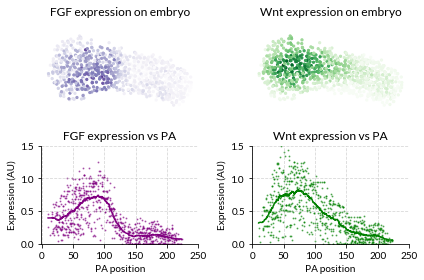

In [53]:
fig, axs = plt.subplots(2,2,
                        sharex = False,
                        # sharey = 'row',
                        tight_layout = True, figsize = (9*2/3, 6*2/3),
                        gridspec_kw={'height_ratios': [1, 1]})



sim = pd.read_csv('../Input/network7_sim_data.csv')
# sim = pd.read_csv('../output/simulations/Sim_samples_run200_AGETs.15_randomnumber.10000_it.200_walkers.1_technicalreplicate.txt_final_timepoint_samp.txt0')
files = os.listdir('../output')

trackIDs = np.random.choice(np.unique(sim['TrackID']), 9)

sim = pd.concat(Simulate_on_tracks(params, list_of_cell_tracks).simulation())

sig_codes = ['FGF', 'Wnt']
cols = ['purple', 'green']
cmaps = ['Purples', 'Greens']

timepoint = 60
sim_subset = sim[sim['Time'] == timepoint]

for k in range(2):
    # ax.plot(sim_subset['Time'], sim_subset[gene_codes[j]], c = col_max[j], linewidth = 1)
    ax = axs[0, k]

    ax.set_title(sig_codes[k])

    ax.scatter(sim_subset['X'], sim_subset['Y'],
               c = sim_subset[sig_codes[k]], cmap = cmaps[k], vmin = 0, vmax = 1.5, s = 5)

    ax.axis('equal')
    ax.axis('off')
    ax = axs[1, k]

    ax.scatter(
        sim_subset['X'], sim_subset[sig_codes[k]],
        c = cols[k], s = 1, alpha = 0.5)#, label = gene_list[k])


    yhat_1 = uniform_filter1d(
        sim_subset.sort_values("X")[sig_codes[k]], size = 75, mode = 'nearest')
    ax.plot(sim_subset.sort_values("X")['X'],
                yhat_1, color = cols[k],
                label = sig_codes[k])





for ax in axs[1].flatten():
    ax.set_ylim(0, 1.5)
    ax.grid(True, linestyle='--', alpha=0.5, zorder= 0)
    # ax.axvline(0, alpha = 0.3, color='black', linewidth=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0, 50, 100, 150, 200, 250])


axs[0, 0].set_title('FGF expression on embryo')
axs[0, 1].set_title('Wnt expression on embryo')

axs[1, 0].set_title('FGF expression vs PA')
axs[1, 1].set_title('Wnt expression vs PA')


axs[1,1].set_xlabel('PA position')
axs[1, 0].set_xlabel('PA position')

axs[1,1].set_ylabel('Expression (AU)')
axs[1, 0].set_ylabel('Expression (AU)')

# fig.suptitle('best parameter set')

plt.savefig('../graphs/signalling on embryo timecourse.png', dpi=500)

In [ ]:
fitted_to_df = pd.concat(fitted_to)
not_fitted_to_df = pd.concat(not_fitted_to)


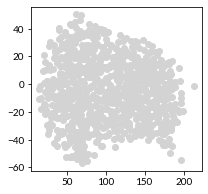

In [ ]:
all_tracks = pd.concat(list_of_cell_tracks)

sim_t1 = all_tracks[all_tracks['Time'] == 1]

plt.figure(figsize=(3, 2.8), tight_layout = True)


plt.scatter(sim_t1['X'], sim_t1['Y'], c = 'lightgrey')





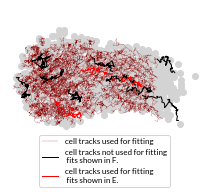

In [ ]:
all_tracks = pd.concat(list_of_cell_tracks)

sim_t1 = all_tracks[all_tracks['Time'] == 1]

plt.figure(figsize=(3, 2.8), tight_layout = True)


plt.scatter(sim_t1['X'], sim_t1['Y'], c = 'lightgrey')
for i, track in enumerate(fitted_to):
    # track = sim[sim['TrackID'] == track_].reset_index(drop = True)
    plt.plot(track['X'], track['Y'],
             c = 'darkred', linewidth = 0.2,
             label = 'cell tracks used for fitting' if i == 0 else "")

for i, track_ in enumerate(trackIDs1):
    track = sim[sim['TrackID'] == track_].reset_index(drop = True)
    plt.plot(track['X'], track['Y'],
             c = 'k', linewidth = 1,
             label = 'cell tracks not used for fitting\n fits shown in F.' if i == 0 else "")

for i, track_ in enumerate(trackIDs2):
    track = sim[sim['TrackID'] == track_].reset_index(drop = True)
    plt.plot(track['X'], track['Y'],
             c = 'red', linewidth = 1,
             label = 'cell tracks used for fitting\n fits shown in E.' if i == 0 else "")


plt.axis('equal')
plt.axis('off')




lgd = plt.legend(
    bbox_to_anchor=(.5, -.3),
    loc='lower center',
    fontsize="8",
    ncol=1  # Number of columns in the legend
)


plt.savefig('../graphs/AGETs fitted to position.png', #bbox_extra_artists=(lgd,),
            bbox_inches='tight', dpi = 500, facecolor='white', transparent=False)



c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


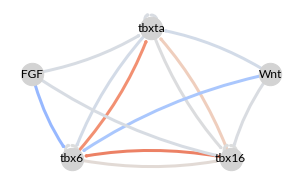

In [ ]:

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["magenta", "lightgrey", "lawngreen"]

cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


# params = np.load('Input/30_clusters_means.npy', allow_pickle = True)[6]

def plot_network(network_name, params):
    from_ = ['tbxta', 'tbx16', 'tbx6', 'tbxta', 'tbx16', 'tbx6', 'tbxta', 'tbx16', 'tbx6', 'Wnt', 'FGF', 'Wnt', 'FGF', 'Wnt', 'FGF']
    to_ = ['tbxta', 'tbxta', 'tbxta', 'tbx16', 'tbx16', 'tbx16', 'tbx6', 'tbx6', 'tbx6', 'tbxta', 'tbxta', 'tbx16', 'tbx16', 'tbx6', 'tbx6']
    params_in =np.hstack([
            [params[0], params[1], params[2]],
            [params[3], params[4], params[5]],
            [params[6], params[7], params[8]],
        [params[18], params[17]], [params[19], params[15]], [params[20], params[16]]
    ]
    )
    params_in = params_in.flatten()

    # Build a dataframe with your connections
    df = pd.DataFrame({'from': from_, 'to': to_, 'value': params_in.astype(float)})
    # Build your graph
    G=nx.from_pandas_edgelist(df, source = 'from', target = 'to', edge_attr = 'value', create_using=nx.DiGraph() )

    # manually set positions
    pos={'FGF':(0,1.3),'Wnt':(3, 1.3),'tbxta':(1.5, 2),'tbx16':(2.5, 0),'tbx6':(0.5,0)}
    # nx.set_node_attributes(G, pos, 'coord')
    # needs to be set before call to nx.draw
    # https://stackoverflow.com/questions/63038379/add-title-to-networkx-plot
    # plt.title(network_name)

    # extract edge color
    # this is important!
    # networkx reorders the node positions
    # so naiievely setting edge_color = df['values']
    # in the call to nx.draw doesn't work
    # instead we need to do this
    edge_colors = [a['value'] for u,v,a in G.edges(data=True)]


    nx.draw(G, pos = pos,
    with_labels=True,
    node_color='lightgrey',
    node_size=500,
    edge_color=edge_colors, # invert the colors
    # width=df['value']/5,
    width = 3, arrowsize=1,
    edge_cmap=plt.cm.coolwarm_r,
    edge_vmin = -20, edge_vmax = 20,
    arrows = True,
    connectionstyle="arc3,rad=0.1")



    plt.savefig('../graphs/MAP_network_topology.svg', dpi = 500)

plt.figure(figsize=(4, 2.5), tight_layout = True)

plot_network('MAP network topology', params)



In [ ]:
print([i for i in params])

[0.6649207002602573, -3.326276331671914, -10.888601525577792, 0.30473957247679245, 0.008157671570151627, -0.7959331154065472, 1.5230912196318251, -12.307874016229528, 0.001100520426661018, 28.517673223797118, 159.90710003344077, 2.7365856165303244, 5.148029361936042, 87.40481066816469, 1.6642573898290554, 0.790550815271675, 8.756625350604827, 0.8151283166472618, 1.6587262490088044, 0.5113998720868309, 6.627076777730141, 0.0611682384103569, -0.9233773508255517, -0.8987024430076592]


c:\Users\shil5659\Anaconda3\envs\AGET\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


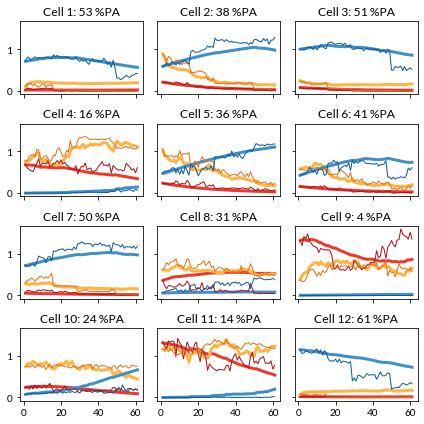

In [ ]:
fig, axs = plt.subplots(4,3, sharex = True, sharey = True, tight_layout = True, figsize = (6,6))


trackIDs = np.random.choice(list_of_cell_tracks, 12)

sim = pd.read_csv(f'../Input/network7_sim_data.csv')

minx = np.min(sim['X'])
maxx = np.max(sim['X'])


sim = Simulate_on_tracks(params, trackIDs).simulation()

for i, track in enumerate(sim):
    sim_subset = track.reset_index(drop = True)
    ax = axs.flatten()[i]
    for j in range(3):
        # ax.plot(sim_subset['Time'], sim_subset[gene_codes[j]], c = col_max[j], linewidth = 1)
        ax.plot(
            sim_subset['Time'],
            sim_subset[gene_codes[j] + '_sim'],
            c = col_list[j], linewidth = 3,
            label = gene_list[j] + ' simulation')
        ap_pos = round((list(sim_subset['X'])[0] - minx) / (maxx - minx) * 100)
        ax.set_title(f'Cell {i+1}: {ap_pos} %PA')



for i, track in enumerate(trackIDs):
    sim_subset = track.reset_index(drop = True)
    ax = axs.flatten()[i]
    for j in range(3):
        ax.plot(sim_subset['Time'], sim_subset[gene_codes[j]], c = col_max[j], linewidth = 1, label = gene_list[j] + ' AGET')


plt.savefig('../graphs/Expression in individual cells 2.png', dpi = 500)
